# attention_layer.py

In [8]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.np import *  # import numpy as np
#from common.layers import Softmax

In [9]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da

In [ ]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

In [ ]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [ ]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

# attention_seq2seq.py 

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.time_layers import *
#from ch07.seq2seq import Encoder, Seq2seq
#from ch08.attention_layer import TimeAttention

In [ ]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [ ]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [ ]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# train.py

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
sys.path.append('../ch07')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
#from common.optimizer import Adam
#from common.trainer import Trainer
#from common.util import eval_seq2seq
#from attention_seq2seq import AttentionSeq2seq
#from ch07.seq2seq import Seq2seq
#from ch07.peeky_seq2seq import PeekySeq2seq

In [ ]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

In [ ]:
# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

In [ ]:
# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

In [ ]:
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

In [ ]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [ ]:
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))
model.save_params()

In [ ]:
model.save_params()

In [ ]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

In [ ]:
"""
| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 20[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 41[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 61[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 81[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 100[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 120[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 140[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 159[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 177[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 195[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 217[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 233[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 247[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 261[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 275[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 289[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 303[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1978-08-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1978-08-11
---
Q october 6, 1992              
T 1992-10-06
☒ 1978-08-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1978-08-11
---
Q 8/30/07                      
T 2007-08-30
☒ 1978-08-11
---
Q 10/28/13                     
T 2013-10-28
☒ 1978-08-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1978-08-11
---
정확도 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.00
| 에폭 2 |  반복 21 / 351 | 시간 14[s] | 손실 1.00
| 에폭 2 |  반복 41 / 351 | 시간 28[s] | 손실 0.99
| 에폭 2 |  반복 61 / 351 | 시간 43[s] | 손실 0.99
| 에폭 2 |  반복 81 / 351 | 시간 57[s] | 손실 0.99
| 에폭 2 |  반복 101 / 351 | 시간 71[s] | 손실 0.99
| 에폭 2 |  반복 121 / 351 | 시간 85[s] | 손실 0.99
| 에폭 2 |  반복 141 / 351 | 시간 99[s] | 손실 0.98
| 에폭 2 |  반복 161 / 351 | 시간 113[s] | 손실 0.98
| 에폭 2 |  반복 181 / 351 | 시간 127[s] | 손실 0.97
| 에폭 2 |  반복 201 / 351 | 시간 141[s] | 손실 0.95
| 에폭 2 |  반복 221 / 351 | 시간 156[s] | 손실 0.94
| 에폭 2 |  반복 241 / 351 | 시간 170[s] | 손실 0.90
| 에폭 2 |  반복 261 / 351 | 시간 184[s] | 손실 0.83
| 에폭 2 |  반복 281 / 351 | 시간 198[s] | 손실 0.74
| 에폭 2 |  반복 301 / 351 | 시간 212[s] | 손실 0.66
| 에폭 2 |  반복 321 / 351 | 시간 226[s] | 손실 0.58
| 에폭 2 |  반복 341 / 351 | 시간 240[s] | 손실 0.46
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 2006-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☒ 2007-08-09
---
Q 10/28/13                     
T 2013-10-28
☒ 1983-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 2016-11-08
---
정확도 51.560%
| 에폭 3 |  반복 1 / 351 | 시간 0[s] | 손실 0.35
| 에폭 3 |  반복 21 / 351 | 시간 9[s] | 손실 0.30
| 에폭 3 |  반복 41 / 351 | 시간 18[s] | 손실 0.21
| 에폭 3 |  반복 61 / 351 | 시간 27[s] | 손실 0.14
| 에폭 3 |  반복 81 / 351 | 시간 36[s] | 손실 0.09
| 에폭 3 |  반복 101 / 351 | 시간 45[s] | 손실 0.07
| 에폭 3 |  반복 121 / 351 | 시간 54[s] | 손실 0.05
| 에폭 3 |  반복 141 / 351 | 시간 63[s] | 손실 0.04
| 에폭 3 |  반복 161 / 351 | 시간 72[s] | 손실 0.03
| 에폭 3 |  반복 181 / 351 | 시간 81[s] | 손실 0.03
| 에폭 3 |  반복 201 / 351 | 시간 90[s] | 손실 0.02
| 에폭 3 |  반복 221 / 351 | 시간 99[s] | 손실 0.02
| 에폭 3 |  반복 241 / 351 | 시간 107[s] | 손실 0.02
| 에폭 3 |  반복 261 / 351 | 시간 116[s] | 손실 0.01
| 에폭 3 |  반복 281 / 351 | 시간 125[s] | 손실 0.01
| 에폭 3 |  반복 301 / 351 | 시간 134[s] | 손실 0.01
| 에폭 3 |  반복 321 / 351 | 시간 143[s] | 손실 0.01
| 에폭 3 |  반복 341 / 351 | 시간 152[s] | 손실 0.01
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.900%
| 에폭 4 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 4 |  반복 21 / 351 | 시간 9[s] | 손실 0.01
| 에폭 4 |  반복 41 / 351 | 시간 18[s] | 손실 0.01
| 에폭 4 |  반복 61 / 351 | 시간 27[s] | 손실 0.01
| 에폭 4 |  반복 81 / 351 | 시간 36[s] | 손실 0.01
| 에폭 4 |  반복 101 / 351 | 시간 45[s] | 손실 0.01
| 에폭 4 |  반복 121 / 351 | 시간 54[s] | 손실 0.00
| 에폭 4 |  반복 141 / 351 | 시간 63[s] | 손실 0.01
| 에폭 4 |  반복 161 / 351 | 시간 72[s] | 손실 0.00
| 에폭 4 |  반복 181 / 351 | 시간 81[s] | 손실 0.00
| 에폭 4 |  반복 201 / 351 | 시간 90[s] | 손실 0.00
| 에폭 4 |  반복 221 / 351 | 시간 99[s] | 손실 0.00
| 에폭 4 |  반복 241 / 351 | 시간 108[s] | 손실 0.00
| 에폭 4 |  반복 261 / 351 | 시간 117[s] | 손실 0.00
| 에폭 4 |  반복 281 / 351 | 시간 126[s] | 손실 0.01
| 에폭 4 |  반복 301 / 351 | 시간 135[s] | 손실 0.00
| 에폭 4 |  반복 321 / 351 | 시간 144[s] | 손실 0.00
| 에폭 4 |  반복 341 / 351 | 시간 153[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.900%
| 에폭 5 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 5 |  반복 21 / 351 | 시간 9[s] | 손실 0.00
| 에폭 5 |  반복 41 / 351 | 시간 18[s] | 손실 0.00
| 에폭 5 |  반복 61 / 351 | 시간 27[s] | 손실 0.00
| 에폭 5 |  반복 81 / 351 | 시간 36[s] | 손실 0.00
| 에폭 5 |  반복 101 / 351 | 시간 45[s] | 손실 0.00
| 에폭 5 |  반복 121 / 351 | 시간 54[s] | 손실 0.00
| 에폭 5 |  반복 141 / 351 | 시간 63[s] | 손실 0.00
| 에폭 5 |  반복 161 / 351 | 시간 72[s] | 손실 0.00
| 에폭 5 |  반복 181 / 351 | 시간 81[s] | 손실 0.00
| 에폭 5 |  반복 201 / 351 | 시간 90[s] | 손실 0.00
| 에폭 5 |  반복 221 / 351 | 시간 99[s] | 손실 0.00
| 에폭 5 |  반복 241 / 351 | 시간 108[s] | 손실 0.00
| 에폭 5 |  반복 261 / 351 | 시간 116[s] | 손실 0.00
| 에폭 5 |  반복 281 / 351 | 시간 125[s] | 손실 0.00
| 에폭 5 |  반복 301 / 351 | 시간 134[s] | 손실 0.00
| 에폭 5 |  반복 321 / 351 | 시간 143[s] | 손실 0.00
| 에폭 5 |  반복 341 / 351 | 시간 152[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.920%
| 에폭 6 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 6 |  반복 21 / 351 | 시간 9[s] | 손실 0.00
| 에폭 6 |  반복 41 / 351 | 시간 18[s] | 손실 0.00
| 에폭 6 |  반복 61 / 351 | 시간 27[s] | 손실 0.00
| 에폭 6 |  반복 81 / 351 | 시간 36[s] | 손실 0.00
| 에폭 6 |  반복 101 / 351 | 시간 45[s] | 손실 0.00
| 에폭 6 |  반복 121 / 351 | 시간 53[s] | 손실 0.00
| 에폭 6 |  반복 141 / 351 | 시간 62[s] | 손실 0.00
| 에폭 6 |  반복 161 / 351 | 시간 71[s] | 손실 0.00
| 에폭 6 |  반복 181 / 351 | 시간 80[s] | 손실 0.00
| 에폭 6 |  반복 201 / 351 | 시간 89[s] | 손실 0.00
| 에폭 6 |  반복 221 / 351 | 시간 98[s] | 손실 0.00
| 에폭 6 |  반복 241 / 351 | 시간 107[s] | 손실 0.00
| 에폭 6 |  반복 261 / 351 | 시간 117[s] | 손실 0.00
| 에폭 6 |  반복 281 / 351 | 시간 125[s] | 손실 0.00
| 에폭 6 |  반복 301 / 351 | 시간 134[s] | 손실 0.00
| 에폭 6 |  반복 321 / 351 | 시간 143[s] | 손실 0.00
| 에폭 6 |  반복 341 / 351 | 시간 152[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.920%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 9[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 18[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 27[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 36[s] | 손실 0.00
| 에폭 7 |  반복 101 / 351 | 시간 44[s] | 손실 0.00
| 에폭 7 |  반복 121 / 351 | 시간 53[s] | 손실 0.00
| 에폭 7 |  반복 141 / 351 | 시간 62[s] | 손실 0.00
| 에폭 7 |  반복 161 / 351 | 시간 71[s] | 손실 0.00
| 에폭 7 |  반복 181 / 351 | 시간 80[s] | 손실 0.00
| 에폭 7 |  반복 201 / 351 | 시간 89[s] | 손실 0.00
| 에폭 7 |  반복 221 / 351 | 시간 98[s] | 손실 0.00
| 에폭 7 |  반복 241 / 351 | 시간 107[s] | 손실 0.00
| 에폭 7 |  반복 261 / 351 | 시간 116[s] | 손실 0.00
| 에폭 7 |  반복 281 / 351 | 시간 125[s] | 손실 0.00
| 에폭 7 |  반복 301 / 351 | 시간 133[s] | 손실 0.00
| 에폭 7 |  반복 321 / 351 | 시간 142[s] | 손실 0.00
| 에폭 7 |  반복 341 / 351 | 시간 152[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.920%
| 에폭 8 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 8 |  반복 21 / 351 | 시간 9[s] | 손실 0.00
| 에폭 8 |  반복 41 / 351 | 시간 18[s] | 손실 0.00
| 에폭 8 |  반복 61 / 351 | 시간 27[s] | 손실 0.00
| 에폭 8 |  반복 81 / 351 | 시간 35[s] | 손실 0.00
| 에폭 8 |  반복 101 / 351 | 시간 44[s] | 손실 0.00
| 에폭 8 |  반복 121 / 351 | 시간 53[s] | 손실 0.00
| 에폭 8 |  반복 141 / 351 | 시간 62[s] | 손실 0.00
| 에폭 8 |  반복 161 / 351 | 시간 71[s] | 손실 0.00
| 에폭 8 |  반복 181 / 351 | 시간 80[s] | 손실 0.00
| 에폭 8 |  반복 201 / 351 | 시간 89[s] | 손실 0.00
| 에폭 8 |  반복 221 / 351 | 시간 98[s] | 손실 0.00
| 에폭 8 |  반복 241 / 351 | 시간 106[s] | 손실 0.00
| 에폭 8 |  반복 261 / 351 | 시간 115[s] | 손실 0.00
| 에폭 8 |  반복 281 / 351 | 시간 124[s] | 손실 0.00
| 에폭 8 |  반복 301 / 351 | 시간 133[s] | 손실 0.00
| 에폭 8 |  반복 321 / 351 | 시간 142[s] | 손실 0.00
| 에폭 8 |  반복 341 / 351 | 시간 150[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.960%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 9 |  반복 21 / 351 | 시간 9[s] | 손실 0.00
| 에폭 9 |  반복 41 / 351 | 시간 18[s] | 손실 0.00
| 에폭 9 |  반복 61 / 351 | 시간 27[s] | 손실 0.00
| 에폭 9 |  반복 81 / 351 | 시간 36[s] | 손실 0.00
| 에폭 9 |  반복 101 / 351 | 시간 44[s] | 손실 0.00
| 에폭 9 |  반복 121 / 351 | 시간 53[s] | 손실 0.00
| 에폭 9 |  반복 141 / 351 | 시간 62[s] | 손실 0.00
| 에폭 9 |  반복 161 / 351 | 시간 71[s] | 손실 0.00
| 에폭 9 |  반복 181 / 351 | 시간 80[s] | 손실 0.00
| 에폭 9 |  반복 201 / 351 | 시간 89[s] | 손실 0.00
| 에폭 9 |  반복 221 / 351 | 시간 98[s] | 손실 0.00
| 에폭 9 |  반복 241 / 351 | 시간 107[s] | 손실 0.00
| 에폭 9 |  반복 261 / 351 | 시간 116[s] | 손실 0.00
| 에폭 9 |  반복 281 / 351 | 시간 125[s] | 손실 0.00
| 에폭 9 |  반복 301 / 351 | 시간 133[s] | 손실 0.00
| 에폭 9 |  반복 321 / 351 | 시간 142[s] | 손실 0.00
| 에폭 9 |  반복 341 / 351 | 시간 151[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.960%
| 에폭 10 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 10 |  반복 21 / 351 | 시간 9[s] | 손실 0.00
| 에폭 10 |  반복 41 / 351 | 시간 18[s] | 손실 0.00
| 에폭 10 |  반복 61 / 351 | 시간 27[s] | 손실 0.00
| 에폭 10 |  반복 81 / 351 | 시간 36[s] | 손실 0.00
| 에폭 10 |  반복 101 / 351 | 시간 44[s] | 손실 0.00
| 에폭 10 |  반복 121 / 351 | 시간 53[s] | 손실 0.00
| 에폭 10 |  반복 141 / 351 | 시간 62[s] | 손실 0.00
| 에폭 10 |  반복 161 / 351 | 시간 71[s] | 손실 0.00
| 에폭 10 |  반복 181 / 351 | 시간 80[s] | 손실 0.00
| 에폭 10 |  반복 201 / 351 | 시간 89[s] | 손실 0.00
| 에폭 10 |  반복 221 / 351 | 시간 98[s] | 손실 0.00
| 에폭 10 |  반복 241 / 351 | 시간 107[s] | 손실 0.00
| 에폭 10 |  반복 261 / 351 | 시간 116[s] | 손실 0.00
| 에폭 10 |  반복 281 / 351 | 시간 124[s] | 손실 0.00
| 에폭 10 |  반복 301 / 351 | 시간 133[s] | 손실 0.00
| 에폭 10 |  반복 321 / 351 | 시간 142[s] | 손실 0.00
| 에폭 10 |  반복 341 / 351 | 시간 151[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.960%
"""

# visualize_attention.py

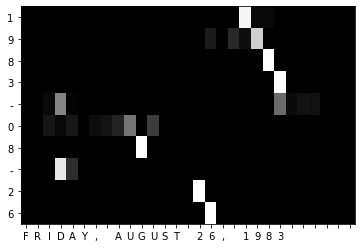

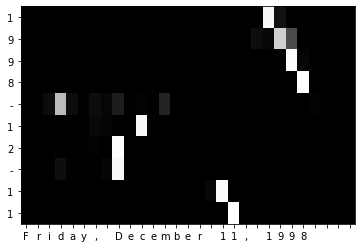

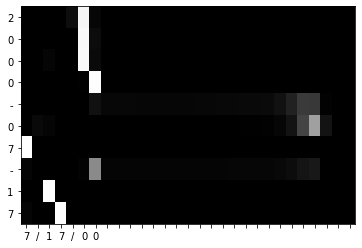

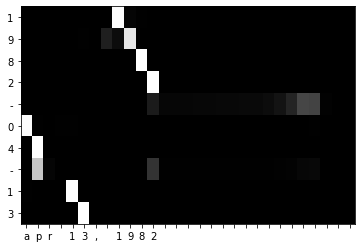

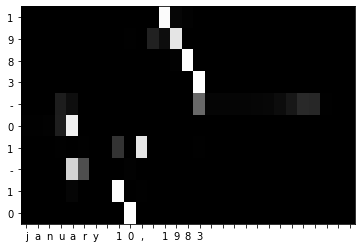

In [7]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
#from attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)


# common_Encoder_

In [4]:
#================================================================================#
#from ch07.seq2seq import Encoder, Seq2seq
#================================================================================#


# coding: utf-8
import sys
sys.path.append('..')
#from common.time_layers import *
#from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


In [18]:
#================================================================================#
#from ch07.peeky_seq2seq import PeekySeq2seq
#================================================================================#

# coding: utf-8
import sys
sys.path.append('..')
#from common.time_layers import *
#from seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


# common_all

In [3]:
#================================================================================#
#base_model.py
#================================================================================#


# coding: utf-8
import sys
sys.path.append('..')
import os
import pickle
#from common.np import *
#from common.util import to_gpu, to_cpu


class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]


#================================================================================#
#config.py
#================================================================================#
# coding: utf-8

GPU = False

#================================================================================#
#functions.py
#================================================================================#
# coding: utf-8
#from common.np import *


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


#================================================================================#
#layers.py
#================================================================================#

# coding: utf-8
#from common.np import *  # import numpy as np
#from common.config import GPU
#from common.functions import softmax, cross_entropy_error


class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

#================================================================================#
#layers.py
#================================================================================#

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None


#================================================================================#
#np.py
#================================================================================#

# coding: utf-8
#from common.config import GPU


if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
    np.add.at = np.scatter_add

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np


#================================================================================#
#optimizer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
#from common.np import *


class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    모멘텀 SGG(Momentum SGD)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    네스테로프 가속 경사(NAG; Nesterov's Accelerated Gradient) (http://arxiv.org/abs/1212.0901)
    '네스테로프 모멘텀 최적화'라고도 한다.
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

#================================================================================#
#time_layers.py
#================================================================================#
# coding: utf-8
#from common.np import *  # import numpy as np (or import cupy as np)
#from common.layers import *
#from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

# ====================================================================== #
# 이 아래의 계층들은 책에서 설명하지 않았거나
# 처리 속도보다는 쉽게 이해할 수 있도록 구현했습니다.
#
# TimeSigmoidWithLoss: 시계열 데이터용 시그모이드 + 손실 계층
# GRU: GRU 계층
# TimeGRU: 시계열 데이터용 GRU 계층
# BiTimeLSTM: 양방향 LSTM 계층
# Simple_TimeSoftmaxWithLoss：간단한 TimeSoftmaxWithLoss 계층의 구현
# Simple_TimeAffine: 간단한 TimeAffine 계층의 구현
# ====================================================================== #


class TimeSigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.xs_shape = None
        self.layers = None

    def forward(self, xs, ts):
        N, T = xs.shape
        self.xs_shape = xs.shape

        self.layers = []
        loss = 0

        for t in range(T):
            layer = SigmoidWithLoss()
            loss += layer.forward(xs[:, t], ts[:, t])
            self.layers.append(layer)

        return loss / T

    def backward(self, dout=1):
        N, T = self.xs_shape
        dxs = np.empty(self.xs_shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t] = layer.backward(dout)

        return dxs


class GRU:
    def __init__(self, Wx, Wh):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        '''
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev


class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        layers = []
        loss = 0

        for t in range(T):
            layer = SoftmaxWithLoss()
            loss += layer.forward(xs[:, t, :], ts[:, t])
            layers.append(layer)
        loss /= T

        self.cache = (layers, xs)
        return loss

    def backward(self, dout=1):
        layers, xs = self.cache
        N, T, V = xs.shape
        dxs = np.empty(xs.shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = layers[t]
            dxs[:, t, :] = layer.backward(dout)

        return dxs


class Simple_TimeAffine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.dW, self.db = None, None
        self.layers = None

    def forward(self, xs):
        N, T, D = xs.shape
        D, M = self.W.shape

        self.layers = []
        out = np.empty((N, T, M), dtype='f')
        for t in range(T):
            layer = Affine(self.W, self.b)
            out[:, t, :] = layer.forward(xs[:, t, :])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, M = dout.shape
        D, M = self.W.shape

        dxs = np.empty((N, T, D), dtype='f')
        self.dW, self.db = 0, 0
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t, :] = layer.backward(dout[:, t, :])

            self.dW += layer.dW
            self.db += layer.db

        return dxs

#================================================================================#
#trainer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
import numpy
import time
import matplotlib.pyplot as plt
#from common.np import *  # import numpy as np
#from common.util import clip_grads


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()


def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


#================================================================================#
#util.py
#================================================================================#

# coding: utf-8
import sys
sys.path.append('..')
import os
#from common.np import *


def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M


def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

